In [ ]:
import kagglehub
import shutil
import os

# Create a visible folder in Colab's working directory
visible_path = "/content/datasets"
os.makedirs(visible_path, exist_ok=True)

# Download the dataset
download_path = kagglehub.dataset_download("pritpal2873/chest-x-ray-dataset-4-categories")

print("Original KaggleHub path:", download_path)

# Copy dataset from hidden cache to visible folder
shutil.copytree(download_path, visible_path, dirs_exist_ok=True)

print("Dataset now visible at:", visible_path)



100%|██████████| 1.74G/1.74G [00:19<00:00, 94.8MB/s]

Extracting files...


Original KaggleHub path: /root/.cache/kagglehub/datasets/pritpal2873/chest-x-ray-dataset-4-categories/versions/1
Dataset now visible at: /content/datasets


In [ ]:
import os
import shutil
import random
from glob import glob

# ====== Paths ======
ORIG_ROOT = "/content/datasets/Chest X_Ray Dataset"   # your actual dataset path
NEW_ROOT = "/content/datasets/chest_xray_split"

# ====== Split ratios ======
train_ratio, val_ratio, test_ratio = 0.7, 0.15, 0.15
random.seed(42)

# ====== Clean old split if exists ======
if os.path.exists(NEW_ROOT):
    shutil.rmtree(NEW_ROOT)
os.makedirs(NEW_ROOT, exist_ok=True)

# ====== Get class folders ======
class_names = [d for d in os.listdir(ORIG_ROOT) if os.path.isdir(os.path.join(ORIG_ROOT, d))]
print(f"Found classes: {class_names}")

# ====== Split each class ======
for class_name in class_names:
    class_dir = os.path.join(ORIG_ROOT, class_name)
    files = glob(os.path.join(class_dir, "*"))
    random.shuffle(files)

    n_total = len(files)
    n_train = int(n_total * train_ratio)
    n_val = int(n_total * val_ratio)
    n_test = n_total - n_train - n_val

    splits = {
        "train": files[:n_train],
        "val": files[n_train:n_train+n_val],
        "test": files[n_train+n_val:]
    }

    for split, split_files in splits.items():
        out_dir = os.path.join(NEW_ROOT, split, class_name)
        os.makedirs(out_dir, exist_ok=True)
        for f in split_files:
            shutil.copy(f, out_dir)

print("✅ Dataset successfully split into:")
print(f"📁 Train: {os.path.join(NEW_ROOT, 'train')}")
print(f"📁 Val:   {os.path.join(NEW_ROOT, 'val')}")
print(f"📁 Test:  {os.path.join(NEW_ROOT, 'test')}")


Found classes: ['COVID19', 'TURBERCULOSIS', 'NORMAL', 'PNEUMONIA']
✅ Dataset successfully split into:
📁 Train: /content/datasets/chest_xray_split/train
📁 Val:   /content/datasets/chest_xray_split/val
📁 Test:  /content/datasets/chest_xray_split/test


In [ ]:
import tensorflow as tf
from tensorflow import keras

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
AUTOTUNE = tf.data.AUTOTUNE

DATA_ROOT = "/content/datasets/chest_xray_split"

# Training dataset
train_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATA_ROOT}/train",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=True
)

# Validation dataset
val_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATA_ROOT}/val",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=True
)

# Test dataset
test_ds = keras.utils.image_dataset_from_directory(
    directory=f"{DATA_ROOT}/test",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=False   # keep test deterministic
)

# ⚡ Performance optimizations
# def prepare(ds, shuffle=False):
#     if shuffle:
#         ds = ds.shuffle(1000)
#     return ds.cache().prefetch(buffer_size=AUTOTUNE)

# train_ds = prepare(train_ds, shuffle=True)
# val_ds   = prepare(val_ds)
# test_ds  = prepare(test_ds)

# Inspect class names
class_names = train_ds.class_names
print("Classes:", class_names)

Found 4991 files belonging to 4 classes.
Found 1068 files belonging to 4 classes.
Found 1073 files belonging to 4 classes.
Classes: ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

BATCH_SIZE = 32
IMG_SIZE = (128, 128)
AUTOTUNE = tf.data.AUTOTUNE

DATA_ROOT = "/content/datasets/chest_xray_split"

# Load datasets
train_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/train",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=True
)

val_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/val",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=True
)

test_ds = keras.utils.image_dataset_from_directory(
    f"{DATA_ROOT}/test",
    labels="inferred",
    label_mode="int",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    color_mode="rgb",
    shuffle=False
)
class_names=train_ds.class_names



# ✅ Data Augmentation (only for training)
data_augmentation = keras.Sequential([
    layers.RandomFlip("horizontal"),
    layers.RandomRotation(0.1),
    layers.RandomZoom(0.1),
])

train_ds = train_ds.map(lambda x, y: (data_augmentation(x, training=True), y),
                        num_parallel_calls=AUTOTUNE)

# ✅ Performance optimizations
train_ds = train_ds.cache().shuffle(1000).prefetch(buffer_size=AUTOTUNE)
val_ds   = val_ds.cache().prefetch(buffer_size=AUTOTUNE)
test_ds  = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4991 files belonging to 4 classes.
Found 1068 files belonging to 4 classes.
Found 1073 files belonging to 4 classes.


In [ ]:
import os

# Define paths
train_dir = "/content/datasets/chest_xray_split/train"
test_dir = "/content/datasets/chest_xray_split/test"
val_dir="/content/datasets/chest_xray_split/val"

# Function to count images
def count_images(directory):
    counts = {}
    for cls in os.listdir(directory):
        class_path = os.path.join(directory, cls)
        if os.path.isdir(class_path):
            counts[cls] = len(os.listdir(class_path))
    return counts

# Count images in train and test folders
train_counts = count_images(train_dir)
test_counts = count_images(test_dir)
val_counts = count_images(val_dir)

# Print counts

print("=== TRAIN SET IMAGE COUNTS ===")
for cls, count in train_counts.items():
    print(f"{cls}: {count} images")

print("\n=== TEST SET IMAGE COUNTS ===")
for cls, count in test_counts.items():
    print(f"{cls}: {count} images")
print("\n=== VAL SET IMAGE COUNTS ===")
for cls, count in val_counts.items():
    print(f"{cls}: {count} images")

# Optional: total summary
print("\nTotal train images:", sum(train_counts.values()))
print("Total test images:", sum(test_counts.values()))
print("Total val images:", sum(val_counts.values()))


=== TRAIN SET IMAGE COUNTS ===
COVID19: 403 images
TURBERCULOSIS: 489 images
NORMAL: 1108 images
PNEUMONIA: 2991 images

=== TEST SET IMAGE COUNTS ===
COVID19: 87 images
TURBERCULOSIS: 106 images
NORMAL: 238 images
PNEUMONIA: 642 images

=== VAL SET IMAGE COUNTS ===
COVID19: 86 images
TURBERCULOSIS: 105 images
NORMAL: 237 images
PNEUMONIA: 640 images

Total train images: 4991
Total test images: 1073
Total val images: 1068


In [ ]:
print(class_names)


['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']


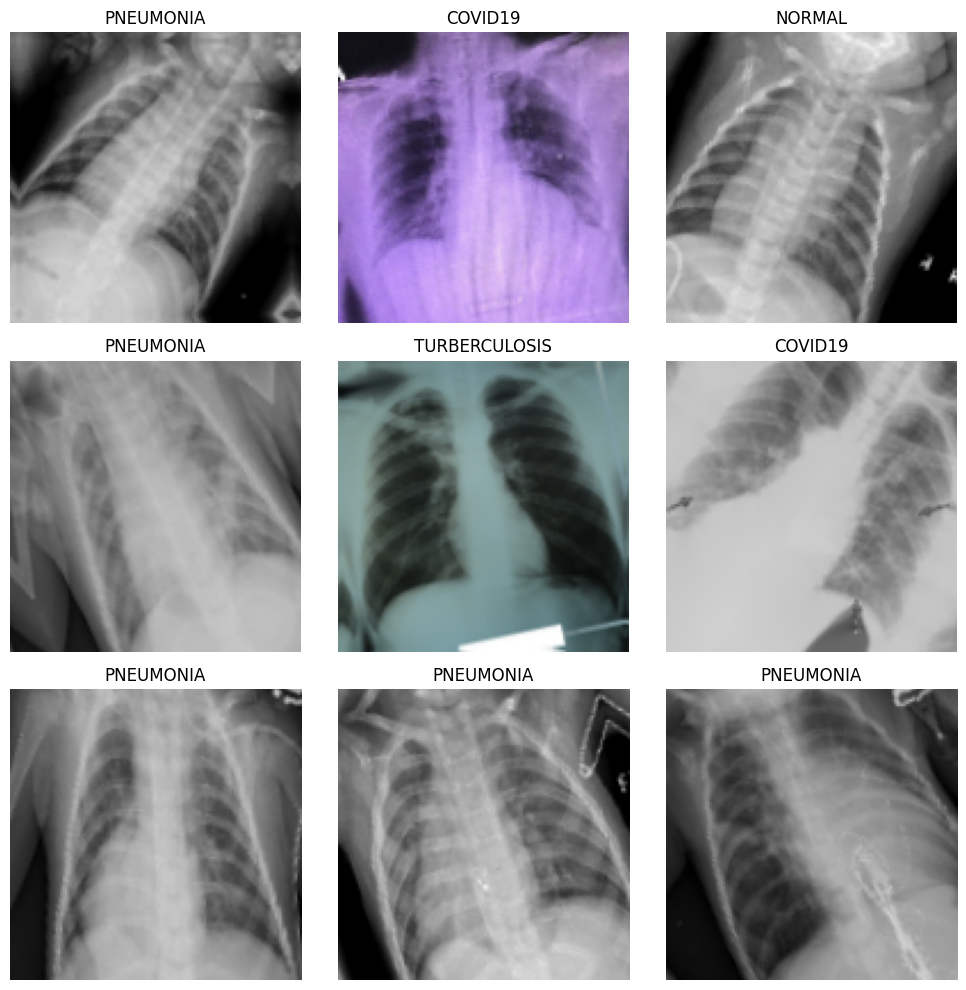

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Get class names
# class_names = train_ds.class_names

# Extract one batch from the dataset
for images, labels in train_ds.take(1):
    images = images.numpy().astype("uint8")
    labels = labels.numpy()

    # Set up subplot grid
    plt.figure(figsize=(10, 10))

    for i in range(9):  # First 9 images
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i])
        plt.title(class_names[labels[i]])
        plt.axis("off")

    plt.tight_layout()
    plt.show()

In [ ]:
from keras import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,BatchNormalization,Input, Dropout

model = Sequential()
model.add(Input(shape=(128,128,3)))
model.add(Conv2D(32, kernel_size=(3, 3),activation='relu',padding="same",))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3),padding='same'))


model.add(Conv2D(64, kernel_size=(3, 3),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3),padding='same'))


model.add(Conv2D(128, kernel_size=(3, 3),activation='relu',padding="same"))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(3, 3),padding='same'))


model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(64, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(4, activation='softmax'))

In [ ]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)               │ (None, 128, 128, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 128, 128, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 43, 43, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 43, 43, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 43, 43, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 15, 15, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 15, 15, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_5           │ (None, 15, 15, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 5, 5, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 3200)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 128)            │       409,728 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 4)              │           260 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 512,388 (1.95 MB)

 Trainable params: 511,940 (1.95 MB)

 Non-trainable params: 448 (1.75 KB)

In [ ]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])



In [ ]:
epochs=20
history = model.fit(train_ds, epochs=epochs, validation_data=val_ds)

Epoch 1/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 48s 262ms/step - accuracy: 0.6259 - loss: 1.7518 - val_accuracy: 0.7397 - val_loss: 0.7480
Epoch 2/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 79s 270ms/step - accuracy: 0.7718 - loss: 0.6038 - val_accuracy: 0.6489 - val_loss: 0.8613
Epoch 3/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 264ms/step - accuracy: 0.8166 - loss: 0.4594 - val_accuracy: 0.8830 - val_loss: 0.3692
Epoch 4/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.8521 - loss: 0.4175 - val_accuracy: 0.9026 - val_loss: 0.3026
Epoch 5/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 238ms/step - accuracy: 0.8651 - loss: 0.3385 - val_accuracy: 0.8848 - val_loss: 0.2687
Epoch 6/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 37s 237ms/step - accuracy: 0.8865 - loss: 0.3484 - val_accuracy: 0.8951 - val_loss: 0.2855
Epoch 7/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 239ms/step - accuracy: 0.9132 - loss: 0.2555 - val_accuracy: 0.9185 - val_loss: 0.2608
Epoch 8/20
156/156 ━━━━━━━━━━━━━━━━━━━━ 41s 237ms/step - accuracy: 0.9177 - loss: 0

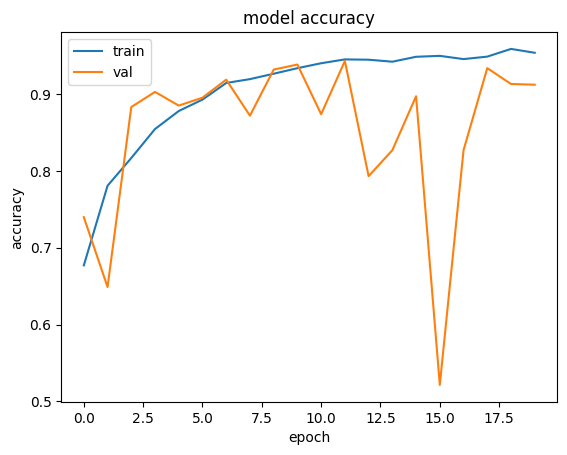

In [ ]:
import matplotlib.pyplot as plt

plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

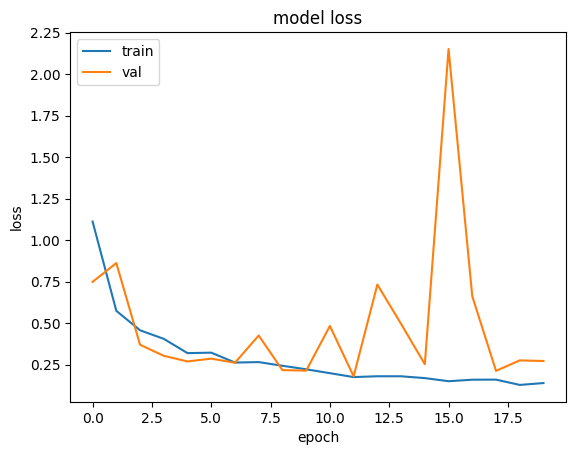

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_accuracy = model.evaluate(val_ds)

print(f"Validation Accuracy: {val_accuracy:.4f}")

34/34 ━━━━━━━━━━━━━━━━━━━━ 7s 195ms/step - accuracy: 0.9111 - loss: 0.2650
Validation Accuracy: 0.9120


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report

# Get class names
class_names = val_ds.class_names

# Step 1: Collect true and predicted labels
y_true = []
y_pred = []

for images, labels in val_ds:
    preds = model.predict(images)
    preds = np.argmax(preds, axis=1)  # get class with highest probability

    y_true.extend(labels.numpy())
    y_pred.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 856ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 89ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 87ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 90ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━

In [ ]:

print("Classification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

Classification Report:
               precision    recall  f1-score   support

      COVID19       0.98      0.69      0.81        86
       NORMAL       0.89      0.93      0.91       237
    PNEUMONIA       0.97      0.92      0.95       640
TURBERCULOSIS       0.67      1.00      0.80       105

     accuracy                           0.91      1068
    macro avg       0.88      0.88      0.87      1068
 weighted avg       0.93      0.91      0.91      1068



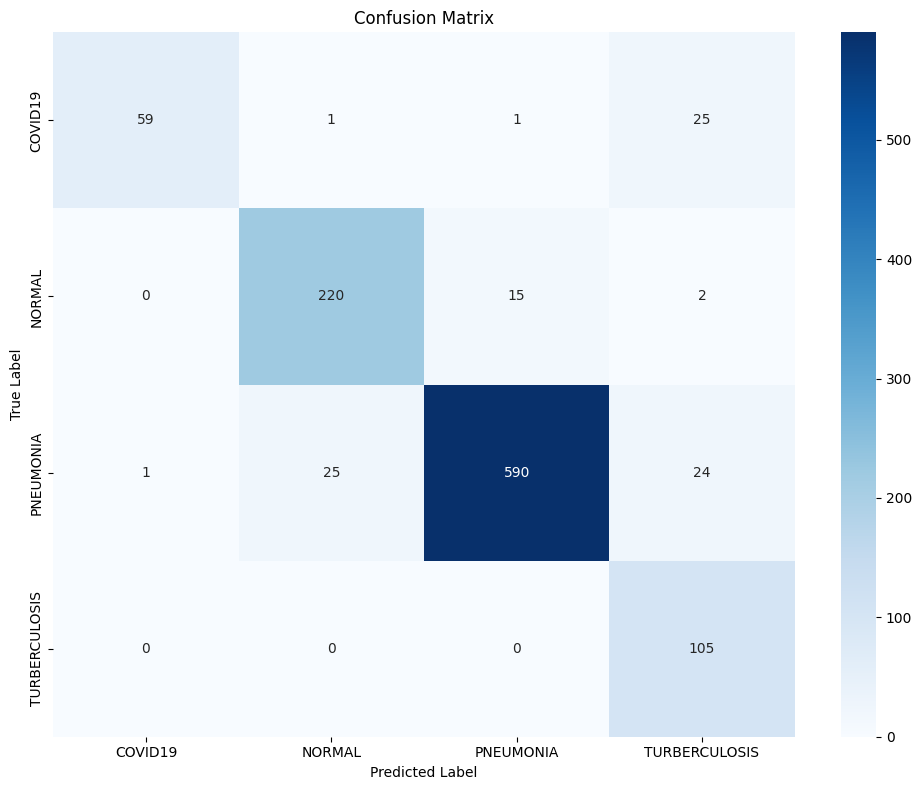

In [ ]:
# Step 3: Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_names, yticklabels=class_names)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.tight_layout()
plt.show()

📸 Total number of photos in test dataset: 1073
✅ Correct predictions out of 15: 3

📊 Test Accuracy: 91.99%
📉 Test Loss: 0.2618


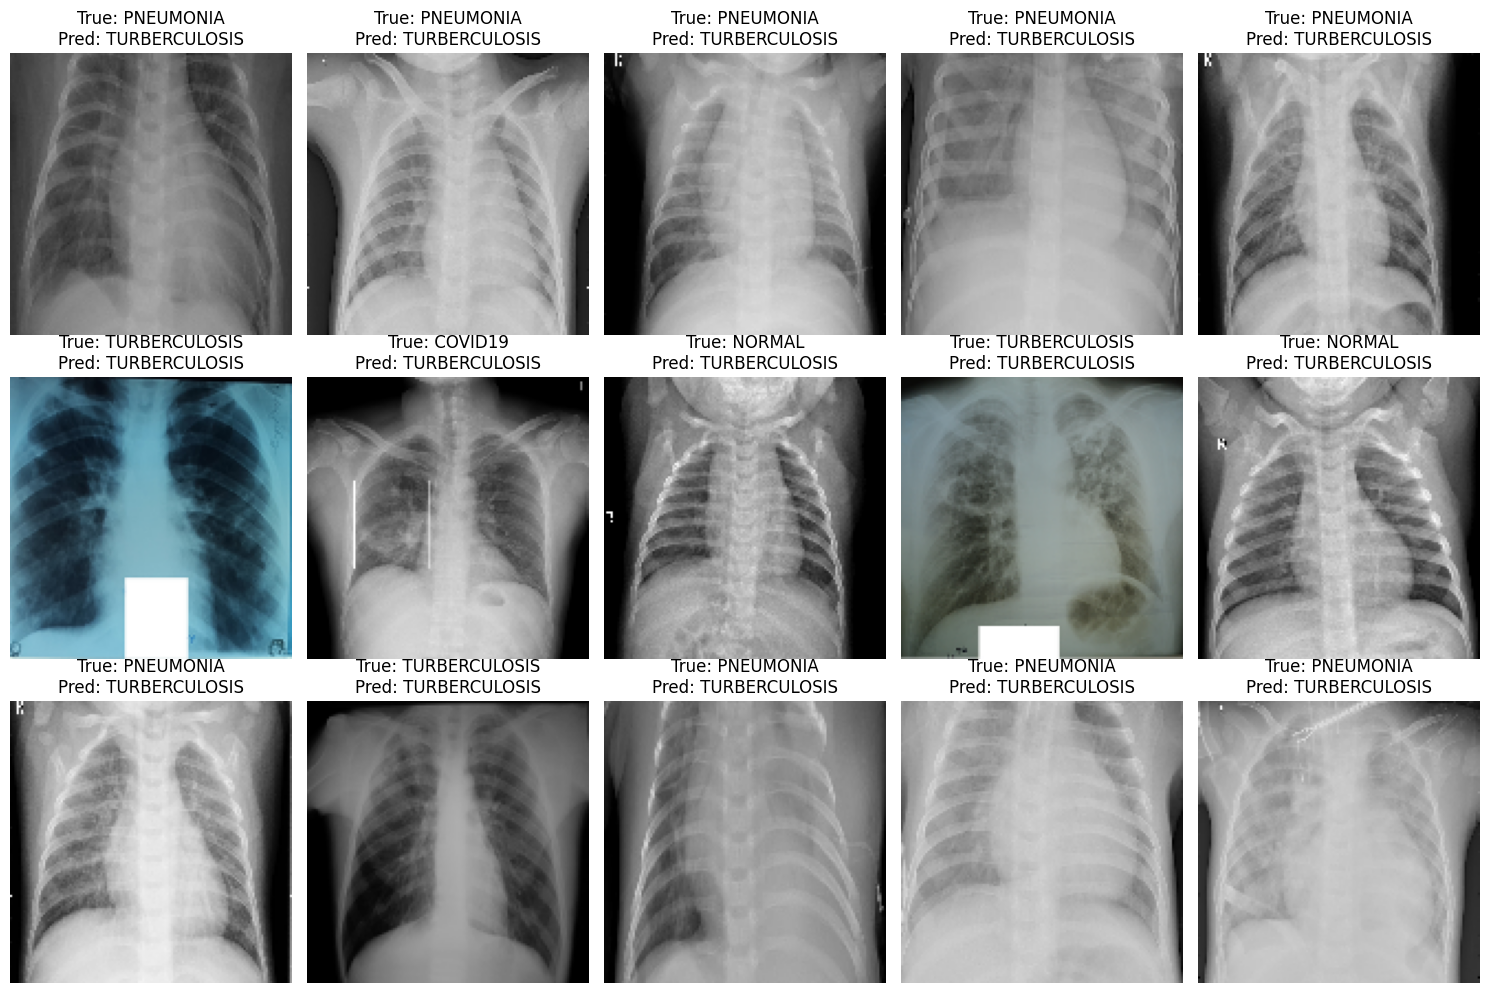

In [ ]:
# ============================================================
# 🧪 MODEL TESTING ON RANDOM TEST IMAGES
# ============================================================

import numpy as np
import matplotlib.pyplot as plt
import random
import os
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Define test directory and class names (based on your dataset)
test_dir = '/content/datasets/chest_xray_split/test'
class_names = ['COVID19', 'NORMAL', 'PNEUMONIA', 'TURBERCULOSIS']  # ⚠️ change to match your folder names

# Verify test directory exists
if not os.path.exists(test_dir):
    raise FileNotFoundError(f"Test directory not found at: {test_dir}")

# Collect all image paths from test directory
all_test_images = []
for class_name in class_names:
    class_path = os.path.join(test_dir, class_name)
    if not os.path.exists(class_path):
        print(f"⚠️ Warning: Directory not found for class {class_name} at {class_path}")
        continue
    images = [os.path.join(class_path, img) for img in os.listdir(class_path)
              if img.lower().endswith(('.jpg', '.jpeg', '.png'))]
    all_test_images.extend(images)

# Total number of photos in test dataset
total_photos = len(all_test_images)
print(f"📸 Total number of photos in test dataset: {total_photos}")

# Check if images were found
if not all_test_images:
    raise ValueError("No images found in the test directory. Please check the dataset structure.")

# Randomly select up to 15 images
random_images = random.sample(all_test_images, min(15, len(all_test_images)))

# Initialize counter for correct predictions
correct_predictions = 0

# Prepare figure for plotting
plt.figure(figsize=(15, 10))

# Process and predict for each image
for i, img_path in enumerate(random_images):
    # Load and preprocess image
    img = load_img(img_path, target_size=(128, 128))  # same size used for training
    img_array = img_to_array(img) / 255.0
    img_array = np.expand_dims(img_array, axis=0)

    # Predict class
    pred = model.predict(img_array, verbose=0)
    pred_class = class_names[np.argmax(pred)]
    true_class = os.path.basename(os.path.dirname(img_path))

    # Check if prediction is correct
    if pred_class.lower() == true_class.lower():
        correct_predictions += 1

    # Plot image with true and predicted labels
    plt.subplot(3, 5, i + 1)
    plt.imshow(img)
    plt.title(f"True: {true_class}\nPred: {pred_class}")
    plt.axis('off')

# Display number of correct predictions
print(f"✅ Correct predictions out of {len(random_images)}: {correct_predictions}")

# Evaluate overall test set performance
test_loss, test_accuracy = model.evaluate(test_ds, verbose=0)
print(f"\n📊 Test Accuracy: {test_accuracy * 100:.2f}%")
print(f"📉 Test Loss: {test_loss:.4f}")

plt.tight_layout()
plt.show()


In [ ]:
pip install gradio

In [ ]:
import gradio as gr
import tensorflow as tf
import numpy as np



# Prediction function
def predict(image):
    # Resize and normalize image
    img = tf.image.resize(image, (128, 128))  # match model input size
    img = tf.expand_dims(img, axis=0)         # add batch dimension


    # Predict
    pred = model.predict(img)
    class_idx = np.argmax(pred[0])
    class_name = class_names[class_idx]
    confidence = float(pred[0][class_idx])

    return {class_name: confidence}

# Gradio interface
interface = gr.Interface(
    fn=predict,
    inputs=gr.Image(type="numpy"),
    outputs=gr.Label(num_top_classes=3),
    title="Chest Disease (Pneumonia, Tuberculosis, Covid) Classifier",
    description="Upload a X-ray image to classify it."
)

# Launch the app
interface.launch()


It looks like you are running Gradio on a hosted Jupyter notebook, which requires `share=True`. Automatically setting `share=True` (you can turn this off by setting `share=False` in `launch()` explicitly).

Colab notebook detected. To show errors in colab notebook, set debug=True in launch()
* Running on public URL: https://c381d56240f2d703b9.gradio.live

This share link expires in 1 week. For free permanent hosting and GPU upgrades, run `gradio deploy` from the terminal in the working directory to deploy to Hugging Face Spaces (https://huggingface.co/spaces)
